# Convolutional Neural Networks for Text Classification

Github: https://github.com/dennybritz/cnn-text-classification-tf

Paper:  https://arxiv.org/pdf/1408.5882.pdf

video：https://www.bilibili.com/video/av64670062

## Task Introduction

### Input

A sentence in the format of a string from the movie comments.

Eg. 1:  "a thoughtful , provocative , insistently humanizing film . "

Eg. 2:  "the effort is sincere and the results are honest , but the film is so bleak that it's hardly watchable ."

### Output

A binary sentiment classification result of the input sentence, 0 indicates negative and 1 indicates positive.

Eg. 1:  1 (positive)

Eg. 2:  0 (negative)

In [1]:
import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input\rt-polarity.neg
./input\rt-polarity.pos


In [2]:
f = open("./input/rt-polarity.neg", "r", encoding='utf-8')
a = f.readlines()
print(len(a))
for i in range(10):
    print(a[i])

5331
simplistic , silly and tedious . 

it's so laddish and juvenile , only teenage boys could possibly find it funny . 

exploitative and largely devoid of the depth or sophistication that would make watching such a graphic treatment of the crimes bearable . 

[garbus] discards the potential for pathological study , exhuming instead , the skewed melodrama of the circumstantial situation . 

a visually flashy but narratively opaque and emotionally vapid exercise in style and mystification . 

the story is also as unoriginal as they come , already having been recycled more times than i'd care to count . 

about the only thing to give the movie points for is bravado -- to take an entirely stale concept and push it through the audience's meat grinder one more time . 

not so much farcical as sour . 

unfortunately the story and the actors are served with a hack script . 

all the more disquieting for its relatively gore-free allusions to the serial murders , but it falls down in its attem

### Data Helpers

In [3]:
import numpy as np
import re

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


def load_data_and_labels(positive_data_file, negative_data_file):
    """
    Loads MR polarity data from files, splits the data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load data from files
    positive_examples = list(open(positive_data_file, "r", encoding='utf-8').readlines())
    positive_examples = [s.strip() for s in positive_examples]
    negative_examples = list(open(negative_data_file, "r", encoding='utf-8').readlines())
    negative_examples = [s.strip() for s in negative_examples]
    # Split by words
    x_text = positive_examples + negative_examples
    x_text = [clean_str(sent) for sent in x_text]
    # Generate labels
    # 第一维表示为负面的概率，第二维表示为正面的概率
    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    return [x_text, y]


def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]


## Model Description

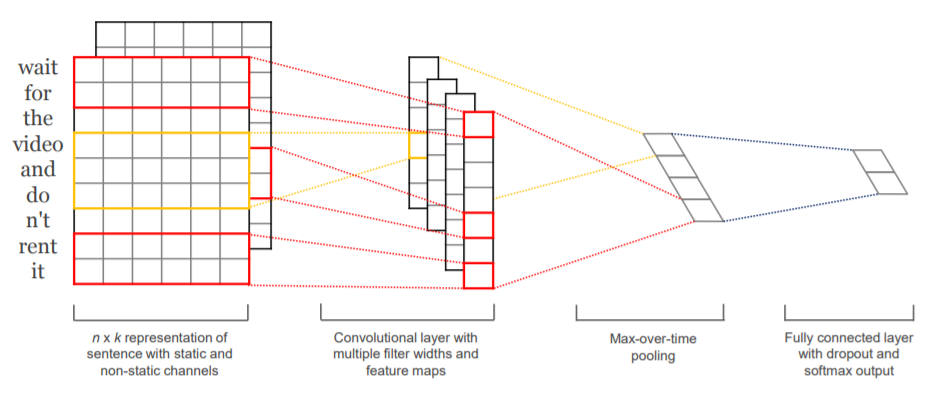

### Embedding Lookup Layer (Line 22 - 28)

You may use Word2vec or GloVe to replace the random initialization.

Tunable hyper parameters:

    embedding_dim

### Convolution Layer (Line 34 - 45)

You may try different nonlinearity other than relu.

Tunable hyper parameters:

    filter_sizes
    num_filters
    
### Max Pooling Layer (Line 46 - 53)

### Fully Connected Layer with Dropout and Softmax Output (Line 60 - 79)

Softmax function:

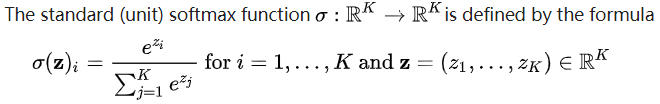

Cross Entropy Loss:

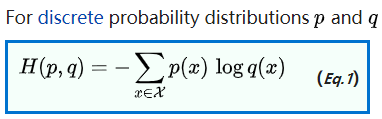

Tunable hyper parameters:

    dropout_keep_prob (only for training)
    l2_reg_lambda

All the tunable hyper parameters can be tuned at the third code block (train).

In [4]:
import tensorflow as tf
import numpy as np


class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(self, sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            # 随机初始化词嵌入，可以改成word2vec
            self.W = tf.Variable(
                tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            # 在最后面增加一个维度，[None, sequence_length, embedding_size，1]
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                # [[batch,1,1,num_filters],[batch,1,1,num_filters],[batch,1,1,num_filters],....]
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        # [batch,1,1,num_filters_total]
        self.h_pool = tf.concat(pooled_outputs, 3)
        # [batch,num_filters_total]
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

### Train

Some tunable training hyper parameters which may influence the results:

    batch_size
    num_epochs
    optimizer (line 94)

All the tunable hyper parameters can be tuned here.

In [5]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
from tensorflow.contrib import learn

# Parameters
# ==================================================

# Data loading params
tf.flags.DEFINE_float("dev_sample_percentage", .1, "Percentage of the training data to use for validation")
tf.flags.DEFINE_string("positive_data_file", "./input/rt-polarity.pos", "Data source for the positive data.")
tf.flags.DEFINE_string("negative_data_file", "./input/rt-polarity.neg", "Data source for the negative data.")

# Model Hyperparameters
tf.flags.DEFINE_integer("embedding_dim", 128, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_string("filter_sizes", "3,4,5", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 128, "Number of filters per filter size (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.0, "L2 regularization lambda (default: 0.0)")

# Training parameters
tf.flags.DEFINE_integer("batch_size", 64, "Batch Size (default: 64)")
tf.flags.DEFINE_integer("num_epochs", 15, "Number of training epochs (default: 20)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 5, "Number of checkpoints to store (default: 5)")
# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

FLAGS = tf.flags.FLAGS
# FLAGS._parse_flags()
# print("\nParameters:")
# for attr, value in sorted(FLAGS.__flags.items()):
#     print("{}={}".format(attr.upper(), value))
# print("")

timestamp = str(int(time.time()))

def preprocess():
    # Data Preparation
    # ==================================================

    # Load data
    print("Loading data...")
    x_text, y = load_data_and_labels(FLAGS.positive_data_file, FLAGS.negative_data_file)

    # Build vocabulary
    max_document_length = max([len(x.split(" ")) for x in x_text])
    vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
    x = np.array(list(vocab_processor.fit_transform(x_text)))

    # Randomly shuffle data
    np.random.seed(10)
    shuffle_indices = np.random.permutation(np.arange(len(y)))
    x_shuffled = x[shuffle_indices]
    y_shuffled = y[shuffle_indices]

    # Split train/test set
    # TODO: This is very crude, should use cross-validation
    dev_sample_index = -1 * int(FLAGS.dev_sample_percentage * float(len(y)))
    x_train, x_dev = x_shuffled[:dev_sample_index], x_shuffled[dev_sample_index:]
    y_train, y_dev = y_shuffled[:dev_sample_index], y_shuffled[dev_sample_index:]

    del x, y, x_shuffled, y_shuffled

    print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
    print("Train/Dev split: {:d}/{:d}".format(len(y_train), len(y_dev)))
    return x_train, y_train, vocab_processor, x_dev, y_dev

def train(x_train, y_train, vocab_processor, x_dev, y_dev):
    # Training
    # ==================================================

    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=FLAGS.allow_soft_placement,
          log_device_placement=FLAGS.log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=FLAGS.embedding_dim,
                filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
                num_filters=FLAGS.num_filters,
                l2_reg_lambda=FLAGS.l2_reg_lambda)

            # Define Training procedure
            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(1e-3)
            grads_and_vars = optimizer.compute_gradients(cnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

            # Keep track of gradient values and sparsity (optional)
            grad_summaries = []
            for g, v in grads_and_vars:
                if g is not None:
                    grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                    sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                    grad_summaries.append(grad_hist_summary)
                    grad_summaries.append(sparsity_summary)
            grad_summaries_merged = tf.summary.merge(grad_summaries)

            # Output directory for models and summaries
            out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
            print("Writing to {}\n".format(out_dir))

            # Summaries for loss and accuracy
            loss_summary = tf.summary.scalar("loss", cnn.loss)
            acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

            # Train Summaries
            train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
            train_summary_dir = os.path.join(out_dir, "summaries", "train")
            train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

            # Dev summaries
            dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
            dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
            dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

            # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

            # Write vocabulary
            vocab_processor.save(os.path.join(out_dir, "vocab"))

            # Initialize all variables
            sess.run(tf.global_variables_initializer())

            def train_step(x_batch, y_batch):
                """
                A single training step
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: FLAGS.dropout_keep_prob
                }
                _, step, summaries, loss, accuracy = sess.run(
                    [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                train_summary_writer.add_summary(summaries, step)

            def dev_step(x_batch, y_batch, writer=None):
                """
                Evaluates model on a dev set
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: 1.0
                }
                step, summaries, loss, accuracy = sess.run(
                    [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if writer:
                    writer.add_summary(summaries, step)

            # Generate batches
            batches = batch_iter(
                list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
            # Training loop. For each batch...
            for batch in batches:
                x_batch, y_batch = zip(*batch)
                train_step(x_batch, y_batch)
                current_step = tf.train.global_step(sess, global_step)
                if current_step % FLAGS.evaluate_every == 0:
                    print("\nEvaluation:")
                    dev_step(x_dev, y_dev, writer=dev_summary_writer)
                    print("")
                if current_step % FLAGS.checkpoint_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                    print("Saved model checkpoint to {}\n".format(path))

def main(argv=None):
    x_train, y_train, vocab_processor, x_dev, y_dev = preprocess()
    train(x_train, y_train, vocab_processor, x_dev, y_dev)

if __name__ == '__main__':
    tf.app.run()

Loading data...
Instructions for updating:
Please use tensorflow/transform or tf.data.


W0429 11:38:06.188759  8284 deprecation.py:323] From <ipython-input-5-204bbea25ab2>:54: VocabularyProcessor.__init__ (from tensorflow.contrib.learn.python.learn.preprocessing.text) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tensorflow/transform or tf.data.


Instructions for updating:
Please use tensorflow/transform or tf.data.


W0429 11:38:06.188759  8284 deprecation.py:323] From D:\anaconda3\envs\tensorflow1.15-cpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\preprocessing\text.py:154: CategoricalVocabulary.__init__ (from tensorflow.contrib.learn.python.learn.preprocessing.categorical_vocabulary) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tensorflow/transform or tf.data.


Instructions for updating:
Please use tensorflow/transform or tf.data.


W0429 11:38:06.204387  8284 deprecation.py:323] From D:\anaconda3\envs\tensorflow1.15-cpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\preprocessing\text.py:170: tokenizer (from tensorflow.contrib.learn.python.learn.preprocessing.text) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tensorflow/transform or tf.data.


Vocabulary Size: 18758
Train/Dev split: 9596/1066
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0429 11:38:06.774735  8284 deprecation.py:506] From <ipython-input-4-93eeefc639d8>:62: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0429 11:38:06.791117  8284 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



W0429 11:38:06.814099  8284 deprecation.py:323] From <ipython-input-4-93eeefc639d8>:78: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.


I0429 11:38:07.066048  8284 summary_op_util.py:66] Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.


INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.


I0429 11:38:07.119035  8284 summary_op_util.py:66] Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.


INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.


I0429 11:38:07.125014  8284 summary_op_util.py:66] Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.


INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.


I0429 11:38:07.161021  8284 summary_op_util.py:66] Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.


INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.


I0429 11:38:07.166995  8284 summary_op_util.py:66] Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.


INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.


I0429 11:38:07.193977  8284 summary_op_util.py:66] Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.


INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/hist is illegal; using conv-maxpool-4/W_0/grad/hist instead.


I0429 11:38:07.198974  8284 summary_op_util.py:66] Summary name conv-maxpool-4/W:0/grad/hist is illegal; using conv-maxpool-4/W_0/grad/hist instead.


INFO:tensorflow:Summary name conv-maxpool-4/W:0/grad/sparsity is illegal; using conv-maxpool-4/W_0/grad/sparsity instead.


I0429 11:38:07.234951  8284 summary_op_util.py:66] Summary name conv-maxpool-4/W:0/grad/sparsity is illegal; using conv-maxpool-4/W_0/grad/sparsity instead.


INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using conv-maxpool-4/b_0/grad/hist instead.


I0429 11:38:07.241947  8284 summary_op_util.py:66] Summary name conv-maxpool-4/b:0/grad/hist is illegal; using conv-maxpool-4/b_0/grad/hist instead.


INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/sparsity is illegal; using conv-maxpool-4/b_0/grad/sparsity instead.


I0429 11:38:07.270933  8284 summary_op_util.py:66] Summary name conv-maxpool-4/b:0/grad/sparsity is illegal; using conv-maxpool-4/b_0/grad/sparsity instead.


INFO:tensorflow:Summary name conv-maxpool-5/W:0/grad/hist is illegal; using conv-maxpool-5/W_0/grad/hist instead.


I0429 11:38:07.277927  8284 summary_op_util.py:66] Summary name conv-maxpool-5/W:0/grad/hist is illegal; using conv-maxpool-5/W_0/grad/hist instead.


INFO:tensorflow:Summary name conv-maxpool-5/W:0/grad/sparsity is illegal; using conv-maxpool-5/W_0/grad/sparsity instead.


I0429 11:38:07.315905  8284 summary_op_util.py:66] Summary name conv-maxpool-5/W:0/grad/sparsity is illegal; using conv-maxpool-5/W_0/grad/sparsity instead.


INFO:tensorflow:Summary name conv-maxpool-5/b:0/grad/hist is illegal; using conv-maxpool-5/b_0/grad/hist instead.


I0429 11:38:07.322901  8284 summary_op_util.py:66] Summary name conv-maxpool-5/b:0/grad/hist is illegal; using conv-maxpool-5/b_0/grad/hist instead.


INFO:tensorflow:Summary name conv-maxpool-5/b:0/grad/sparsity is illegal; using conv-maxpool-5/b_0/grad/sparsity instead.


I0429 11:38:07.355883  8284 summary_op_util.py:66] Summary name conv-maxpool-5/b:0/grad/sparsity is illegal; using conv-maxpool-5/b_0/grad/sparsity instead.


INFO:tensorflow:Summary name W:0/grad/hist is illegal; using W_0/grad/hist instead.


I0429 11:38:07.363877  8284 summary_op_util.py:66] Summary name W:0/grad/hist is illegal; using W_0/grad/hist instead.


INFO:tensorflow:Summary name W:0/grad/sparsity is illegal; using W_0/grad/sparsity instead.


I0429 11:38:07.396857  8284 summary_op_util.py:66] Summary name W:0/grad/sparsity is illegal; using W_0/grad/sparsity instead.


INFO:tensorflow:Summary name output/b:0/grad/hist is illegal; using output/b_0/grad/hist instead.


I0429 11:38:07.400856  8284 summary_op_util.py:66] Summary name output/b:0/grad/hist is illegal; using output/b_0/grad/hist instead.


INFO:tensorflow:Summary name output/b:0/grad/sparsity is illegal; using output/b_0/grad/sparsity instead.


I0429 11:38:07.427839  8284 summary_op_util.py:66] Summary name output/b:0/grad/sparsity is illegal; using output/b_0/grad/sparsity instead.


Writing to E:\Project\伯禹自然语言处理\03基于卷积神经网络的文本分类\runs\1588131485

2020-04-29T11:38:08.745096: step 1, loss 2.51557, acc 0.53125
2020-04-29T11:38:08.944150: step 2, loss 2.06716, acc 0.53125
2020-04-29T11:38:09.145035: step 3, loss 1.72793, acc 0.546875
2020-04-29T11:38:09.340921: step 4, loss 2.37388, acc 0.484375
2020-04-29T11:38:09.549802: step 5, loss 2.17035, acc 0.515625
2020-04-29T11:38:09.740339: step 6, loss 1.86862, acc 0.5625
2020-04-29T11:38:09.910865: step 7, loss 1.63498, acc 0.640625
2020-04-29T11:38:10.096393: step 8, loss 2.37348, acc 0.53125
2020-04-29T11:38:10.256005: step 9, loss 1.86854, acc 0.609375
2020-04-29T11:38:10.451704: step 10, loss 2.78262, acc 0.40625
2020-04-29T11:38:10.650589: step 11, loss 1.55885, acc 0.5
2020-04-29T11:38:10.822902: step 12, loss 1.45327, acc 0.546875
2020-04-29T11:38:11.003520: step 13, loss 2.6656, acc 0.46875
2020-04-29T11:38:11.168424: step 14, loss 1.957, acc 0.5625
2020-04-29T11:38:11.337308: step 15, loss 1.61012, acc 0.484375
20

2020-04-29T11:38:32.364432: step 128, loss 1.25514, acc 0.59375
2020-04-29T11:38:32.536591: step 129, loss 1.19885, acc 0.53125
2020-04-29T11:38:32.762669: step 130, loss 1.81976, acc 0.53125
2020-04-29T11:38:32.982542: step 131, loss 1.22768, acc 0.578125
2020-04-29T11:38:33.176431: step 132, loss 1.37515, acc 0.5
2020-04-29T11:38:33.334055: step 133, loss 1.00475, acc 0.640625
2020-04-29T11:38:33.553187: step 134, loss 1.62492, acc 0.515625
2020-04-29T11:38:33.742077: step 135, loss 1.24625, acc 0.453125
2020-04-29T11:38:33.953964: step 136, loss 1.33309, acc 0.578125
2020-04-29T11:38:34.144846: step 137, loss 1.17793, acc 0.59375
2020-04-29T11:38:34.324786: step 138, loss 1.69571, acc 0.4375
2020-04-29T11:38:34.530667: step 139, loss 1.31817, acc 0.546875
2020-04-29T11:38:34.701435: step 140, loss 1.22115, acc 0.546875
2020-04-29T11:38:34.871928: step 141, loss 1.00176, acc 0.625
2020-04-29T11:38:35.043752: step 142, loss 1.31794, acc 0.46875
2020-04-29T11:38:35.250631: step 143, lo

2020-04-29T11:38:55.087087: step 254, loss 1.05975, acc 0.578125
2020-04-29T11:38:55.258950: step 255, loss 0.528165, acc 0.75
2020-04-29T11:38:55.423056: step 256, loss 0.801192, acc 0.6875
2020-04-29T11:38:55.594919: step 257, loss 0.874168, acc 0.625
2020-04-29T11:38:55.762108: step 258, loss 1.08388, acc 0.515625
2020-04-29T11:38:55.918346: step 259, loss 0.939111, acc 0.5
2020-04-29T11:38:56.096890: step 260, loss 1.26976, acc 0.53125
2020-04-29T11:38:56.253130: step 261, loss 0.626862, acc 0.671875
2020-04-29T11:38:56.439763: step 262, loss 0.86539, acc 0.640625
2020-04-29T11:38:56.596000: step 263, loss 0.699755, acc 0.671875
2020-04-29T11:38:56.775925: step 264, loss 1.09983, acc 0.5
2020-04-29T11:38:56.932164: step 265, loss 0.915337, acc 0.546875
2020-04-29T11:38:57.120207: step 266, loss 0.854685, acc 0.515625
2020-04-29T11:38:57.284502: step 267, loss 0.932655, acc 0.625
2020-04-29T11:38:57.457532: step 268, loss 0.704901, acc 0.71875
2020-04-29T11:38:57.613771: step 269, l

2020-04-29T11:39:17.111916: step 379, loss 0.591738, acc 0.6875
2020-04-29T11:39:17.283779: step 380, loss 0.525304, acc 0.765625
2020-04-29T11:39:17.452597: step 381, loss 0.69345, acc 0.6875
2020-04-29T11:39:17.608836: step 382, loss 0.467359, acc 0.796875
2020-04-29T11:39:17.781253: step 383, loss 0.738953, acc 0.59375
2020-04-29T11:39:17.953117: step 384, loss 0.597852, acc 0.625
2020-04-29T11:39:18.114521: step 385, loss 0.654666, acc 0.640625
2020-04-29T11:39:18.286385: step 386, loss 0.651089, acc 0.640625
2020-04-29T11:39:18.458326: step 387, loss 0.690781, acc 0.671875
2020-04-29T11:39:18.614565: step 388, loss 0.716736, acc 0.640625
2020-04-29T11:39:18.797641: step 389, loss 0.760537, acc 0.6875
2020-04-29T11:39:18.953879: step 390, loss 0.686615, acc 0.6875
2020-04-29T11:39:19.131049: step 391, loss 0.59447, acc 0.640625
2020-04-29T11:39:19.302911: step 392, loss 0.766798, acc 0.640625
2020-04-29T11:39:19.475054: step 393, loss 0.574313, acc 0.703125
2020-04-29T11:39:19.6312

2020-04-29T11:39:39.459084: step 502, loss 0.646045, acc 0.75
2020-04-29T11:39:39.630948: step 503, loss 0.633835, acc 0.625
2020-04-29T11:39:39.804342: step 504, loss 0.53953, acc 0.703125
2020-04-29T11:39:39.982142: step 505, loss 0.487029, acc 0.71875
2020-04-29T11:39:40.157041: step 506, loss 0.523434, acc 0.71875
2020-04-29T11:39:40.321177: step 507, loss 0.566152, acc 0.6875
2020-04-29T11:39:40.493040: step 508, loss 0.40036, acc 0.78125
2020-04-29T11:39:40.671536: step 509, loss 0.601104, acc 0.65625
2020-04-29T11:39:40.827774: step 510, loss 0.592606, acc 0.734375
2020-04-29T11:39:41.009757: step 511, loss 0.604668, acc 0.703125
2020-04-29T11:39:41.177659: step 512, loss 0.715723, acc 0.5625
2020-04-29T11:39:41.340296: step 513, loss 0.69057, acc 0.609375
2020-04-29T11:39:41.512159: step 514, loss 0.667882, acc 0.59375
2020-04-29T11:39:41.690177: step 515, loss 0.473406, acc 0.78125
2020-04-29T11:39:41.846415: step 516, loss 0.545009, acc 0.75
2020-04-29T11:39:42.023274: step 5

W0429 11:39:56.855234  8284 deprecation.py:323] From D:\anaconda3\envs\tensorflow1.15-cpu\lib\site-packages\tensorflow_core\python\training\saver.py:963: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Saved model checkpoint to E:\Project\伯禹自然语言处理\03基于卷积神经网络的文本分类\runs\1588131485\checkpoints\model-600

2020-04-29T11:39:57.143908: step 601, loss 0.667614, acc 0.671875
2020-04-29T11:39:57.330561: step 602, loss 0.547117, acc 0.703125
2020-04-29T11:39:57.490376: step 603, loss 0.507832, acc 0.71875
2020-04-29T11:39:57.660314: step 604, loss 0.553227, acc 0.671875
2020-04-29T11:39:57.832176: step 605, loss 0.589016, acc 0.703125
2020-04-29T11:39:58.014733: step 606, loss 0.527682, acc 0.734375
2020-04-29T11:39:58.164803: step 607, loss 0.494944, acc 0.75
2020-04-29T11:39:58.343197: step 608, loss 0.500427, acc 0.71875
2020-04-29T11:39:58.515059: step 609, loss 0.501485, acc 0.75
2020-04-29T11:39:58.675943: step 610, loss 0.437731, acc 0.734375
2020-04-29T11:39:58.847806: step 611, loss 0.562526, acc 0.703125
2020-04-29T11:39:59.021345: step 612, loss 0.44873, acc 0.84375
2020-04-29T11:39:59.186121: step 613, loss 0.572331, acc 0.6875
2020-04-29T11:39:59.343478: step 614, loss 0.496111, ac

2020-04-29T11:40:18.731781: step 724, loss 0.566594, acc 0.703125
2020-04-29T11:40:18.903644: step 725, loss 0.496566, acc 0.796875
2020-04-29T11:40:19.071282: step 726, loss 0.507369, acc 0.71875
2020-04-29T11:40:19.227521: step 727, loss 0.475415, acc 0.78125
2020-04-29T11:40:19.399134: step 728, loss 0.477194, acc 0.765625
2020-04-29T11:40:19.570997: step 729, loss 0.521888, acc 0.71875
2020-04-29T11:40:19.747837: step 730, loss 0.36037, acc 0.859375
2020-04-29T11:40:19.904076: step 731, loss 0.515189, acc 0.8125
2020-04-29T11:40:20.084878: step 732, loss 0.563586, acc 0.703125
2020-04-29T11:40:20.256740: step 733, loss 0.624741, acc 0.6875
2020-04-29T11:40:20.419300: step 734, loss 0.633417, acc 0.625
2020-04-29T11:40:20.591163: step 735, loss 0.452829, acc 0.796875
2020-04-29T11:40:20.765879: step 736, loss 0.475649, acc 0.765625
2020-04-29T11:40:20.922117: step 737, loss 0.532808, acc 0.734375
2020-04-29T11:40:21.105950: step 738, loss 0.419881, acc 0.84375
2020-04-29T11:40:21.25

2020-04-29T11:40:40.672665: step 849, loss 0.453237, acc 0.84375
2020-04-29T11:40:40.844528: step 850, loss 0.475455, acc 0.71875
2020-04-29T11:40:41.024596: step 851, loss 0.337746, acc 0.84375
2020-04-29T11:40:41.174917: step 852, loss 0.52733, acc 0.71875
2020-04-29T11:40:41.355224: step 853, loss 0.472772, acc 0.78125
2020-04-29T11:40:41.511464: step 854, loss 0.600945, acc 0.671875
2020-04-29T11:40:41.688567: step 855, loss 0.476468, acc 0.796875
2020-04-29T11:40:41.844806: step 856, loss 0.604312, acc 0.71875
2020-04-29T11:40:42.025426: step 857, loss 0.454237, acc 0.8125
2020-04-29T11:40:42.181665: step 858, loss 0.353017, acc 0.828125
2020-04-29T11:40:42.363317: step 859, loss 0.50278, acc 0.75
2020-04-29T11:40:42.519557: step 860, loss 0.356971, acc 0.828125
2020-04-29T11:40:42.691268: step 861, loss 0.435626, acc 0.828125
2020-04-29T11:40:42.847508: step 862, loss 0.408143, acc 0.84375
2020-04-29T11:40:43.024114: step 863, loss 0.516518, acc 0.75
2020-04-29T11:40:43.180354: s

2020-04-29T11:41:02.532894: step 974, loss 0.429268, acc 0.78125
2020-04-29T11:41:02.704756: step 975, loss 0.359502, acc 0.859375
2020-04-29T11:41:02.878692: step 976, loss 0.311603, acc 0.875
2020-04-29T11:41:03.033003: step 977, loss 0.369748, acc 0.765625
2020-04-29T11:41:03.212267: step 978, loss 0.424658, acc 0.796875
2020-04-29T11:41:03.368506: step 979, loss 0.476071, acc 0.78125
2020-04-29T11:41:03.546797: step 980, loss 0.413209, acc 0.828125
2020-04-29T11:41:03.718661: step 981, loss 0.29993, acc 0.890625
2020-04-29T11:41:03.897003: step 982, loss 0.419236, acc 0.78125
2020-04-29T11:41:04.053242: step 983, loss 0.305517, acc 0.90625
2020-04-29T11:41:04.230311: step 984, loss 0.280582, acc 0.875
2020-04-29T11:41:04.386549: step 985, loss 0.424689, acc 0.8125
2020-04-29T11:41:04.564514: step 986, loss 0.368776, acc 0.84375
2020-04-29T11:41:04.736376: step 987, loss 0.289971, acc 0.875
2020-04-29T11:41:04.899086: step 988, loss 0.328377, acc 0.875
2020-04-29T11:41:05.070949: st

2020-04-29T11:41:24.013940: step 1096, loss 0.272651, acc 0.90625
2020-04-29T11:41:24.186925: step 1097, loss 0.180317, acc 0.921875
2020-04-29T11:41:24.353609: step 1098, loss 0.27081, acc 0.890625
2020-04-29T11:41:24.541096: step 1099, loss 0.421057, acc 0.796875
2020-04-29T11:41:24.719478: step 1100, loss 0.26492, acc 0.90625

Evaluation:
2020-04-29T11:41:24.969098: step 1100, loss 0.574256, acc 0.710131

Saved model checkpoint to E:\Project\伯禹自然语言处理\03基于卷积神经网络的文本分类\runs\1588131485\checkpoints\model-1100

2020-04-29T11:41:25.615782: step 1101, loss 0.2598, acc 0.84375
2020-04-29T11:41:25.789109: step 1102, loss 0.298336, acc 0.859375
2020-04-29T11:41:25.972559: step 1103, loss 0.3936, acc 0.828125
2020-04-29T11:41:26.156332: step 1104, loss 0.440188, acc 0.75
2020-04-29T11:41:26.336680: step 1105, loss 0.298369, acc 0.890625
2020-04-29T11:41:26.505650: step 1106, loss 0.259052, acc 0.890625
2020-04-29T11:41:26.677513: step 1107, loss 0.309287, acc 0.828125
2020-04-29T11:41:26.866684

2020-04-29T11:41:46.399013: step 1216, loss 0.305799, acc 0.859375
2020-04-29T11:41:46.555253: step 1217, loss 0.240863, acc 0.890625
2020-04-29T11:41:46.726829: step 1218, loss 0.238439, acc 0.890625
2020-04-29T11:41:46.898691: step 1219, loss 0.266401, acc 0.90625
2020-04-29T11:41:47.078249: step 1220, loss 0.359175, acc 0.84375
2020-04-29T11:41:47.239232: step 1221, loss 0.173819, acc 0.953125
2020-04-29T11:41:47.413287: step 1222, loss 0.36401, acc 0.8125
2020-04-29T11:41:47.569525: step 1223, loss 0.283761, acc 0.859375
2020-04-29T11:41:47.748071: step 1224, loss 0.356567, acc 0.84375
2020-04-29T11:41:47.919933: step 1225, loss 0.27158, acc 0.921875
2020-04-29T11:41:48.095128: step 1226, loss 0.26024, acc 0.890625
2020-04-29T11:41:48.266992: step 1227, loss 0.216648, acc 0.890625
2020-04-29T11:41:48.429391: step 1228, loss 0.370069, acc 0.796875
2020-04-29T11:41:48.601252: step 1229, loss 0.187618, acc 0.953125
2020-04-29T11:41:48.764563: step 1230, loss 0.198312, acc 0.953125
202

2020-04-29T11:42:08.086911: step 1339, loss 0.204827, acc 0.9375
2020-04-29T11:42:08.238892: step 1340, loss 0.204056, acc 0.921875
2020-04-29T11:42:08.417885: step 1341, loss 0.182868, acc 0.9375
2020-04-29T11:42:08.574124: step 1342, loss 0.255924, acc 0.890625
2020-04-29T11:42:08.754825: step 1343, loss 0.241062, acc 0.875
2020-04-29T11:42:08.926689: step 1344, loss 0.293536, acc 0.859375
2020-04-29T11:42:09.085013: step 1345, loss 0.408377, acc 0.890625
2020-04-29T11:42:09.256876: step 1346, loss 0.240697, acc 0.859375
2020-04-29T11:42:09.424198: step 1347, loss 0.218262, acc 0.9375
2020-04-29T11:42:09.596061: step 1348, loss 0.339352, acc 0.828125
2020-04-29T11:42:09.753378: step 1349, loss 0.196757, acc 0.90625
2020-04-29T11:42:09.925241: step 1350, loss 0.252263, acc 0.866667
2020-04-29T11:42:10.087277: step 1351, loss 0.175206, acc 0.90625
2020-04-29T11:42:10.259140: step 1352, loss 0.245507, acc 0.875
2020-04-29T11:42:10.420639: step 1353, loss 0.122607, acc 0.96875
2020-04-29

2020-04-29T11:42:29.631386: step 1462, loss 0.138867, acc 0.9375
2020-04-29T11:42:29.787626: step 1463, loss 0.139913, acc 0.9375
2020-04-29T11:42:29.979272: step 1464, loss 0.238542, acc 0.890625
2020-04-29T11:42:30.143178: step 1465, loss 0.194014, acc 0.90625
2020-04-29T11:42:30.305786: step 1466, loss 0.156031, acc 0.953125
2020-04-29T11:42:30.462026: step 1467, loss 0.244314, acc 0.9375
2020-04-29T11:42:30.642119: step 1468, loss 0.32085, acc 0.890625
2020-04-29T11:42:30.813981: step 1469, loss 0.129247, acc 0.96875
2020-04-29T11:42:30.990109: step 1470, loss 0.177657, acc 0.953125
2020-04-29T11:42:31.146349: step 1471, loss 0.222289, acc 0.90625
2020-04-29T11:42:31.311726: step 1472, loss 0.212656, acc 0.875
2020-04-29T11:42:31.483590: step 1473, loss 0.147164, acc 0.96875
2020-04-29T11:42:31.652244: step 1474, loss 0.140648, acc 0.953125
2020-04-29T11:42:31.808482: step 1475, loss 0.191085, acc 0.90625
2020-04-29T11:42:31.990843: step 1476, loss 0.167113, acc 0.921875
2020-04-29

2020-04-29T11:42:51.090775: step 1583, loss 0.123316, acc 0.953125
2020-04-29T11:42:51.254680: step 1584, loss 0.139423, acc 0.9375
2020-04-29T11:42:51.417737: step 1585, loss 0.166593, acc 0.921875
2020-04-29T11:42:51.589600: step 1586, loss 0.150543, acc 0.953125
2020-04-29T11:42:51.749978: step 1587, loss 0.151224, acc 0.9375
2020-04-29T11:42:51.921841: step 1588, loss 0.0897073, acc 0.96875
2020-04-29T11:42:52.099346: step 1589, loss 0.114576, acc 0.96875
2020-04-29T11:42:52.271210: step 1590, loss 0.104905, acc 0.96875
2020-04-29T11:42:52.438468: step 1591, loss 0.159054, acc 0.953125
2020-04-29T11:42:52.594708: step 1592, loss 0.172379, acc 0.90625
2020-04-29T11:42:52.772998: step 1593, loss 0.110001, acc 0.953125
2020-04-29T11:42:52.929237: step 1594, loss 0.102174, acc 0.953125
2020-04-29T11:42:53.096528: step 1595, loss 0.208384, acc 0.890625
2020-04-29T11:42:53.268391: step 1596, loss 0.14349, acc 0.921875
2020-04-29T11:42:53.440972: step 1597, loss 0.110716, acc 0.96875
2020

2020-04-29T11:43:12.887135: step 1702, loss 0.0868087, acc 0.96875
2020-04-29T11:43:13.058998: step 1703, loss 0.173511, acc 0.953125
2020-04-29T11:43:13.223987: step 1704, loss 0.154938, acc 0.9375
2020-04-29T11:43:13.395849: step 1705, loss 0.129652, acc 0.953125
2020-04-29T11:43:13.573577: step 1706, loss 0.127126, acc 0.953125
2020-04-29T11:43:13.745441: step 1707, loss 0.143436, acc 0.921875
2020-04-29T11:43:13.922780: step 1708, loss 0.0617736, acc 0.984375
2020-04-29T11:43:14.094642: step 1709, loss 0.154607, acc 0.9375
2020-04-29T11:43:14.273083: step 1710, loss 0.177947, acc 0.921875
2020-04-29T11:43:14.444947: step 1711, loss 0.16413, acc 0.96875
2020-04-29T11:43:14.623866: step 1712, loss 0.114483, acc 0.953125
2020-04-29T11:43:14.795729: step 1713, loss 0.145192, acc 0.953125
2020-04-29T11:43:14.977471: step 1714, loss 0.22124, acc 0.875
2020-04-29T11:43:15.142056: step 1715, loss 0.16917, acc 0.953125
2020-04-29T11:43:15.318333: step 1716, loss 0.164669, acc 0.9375
2020-04

2020-04-29T11:43:34.532289: step 1823, loss 0.0758401, acc 0.953125
2020-04-29T11:43:34.697111: step 1824, loss 0.0686773, acc 0.96875
2020-04-29T11:43:34.880672: step 1825, loss 0.087252, acc 0.96875
2020-04-29T11:43:35.036911: step 1826, loss 0.0605189, acc 0.984375
2020-04-29T11:43:35.212978: step 1827, loss 0.122352, acc 0.96875
2020-04-29T11:43:35.384842: step 1828, loss 0.0600028, acc 0.984375
2020-04-29T11:43:35.562009: step 1829, loss 0.0994095, acc 0.96875
2020-04-29T11:43:35.718248: step 1830, loss 0.128123, acc 0.953125
2020-04-29T11:43:35.905637: step 1831, loss 0.0571886, acc 0.984375
2020-04-29T11:43:36.061877: step 1832, loss 0.076395, acc 0.96875
2020-04-29T11:43:36.235057: step 1833, loss 0.0871811, acc 0.984375
2020-04-29T11:43:36.406921: step 1834, loss 0.145182, acc 0.921875
2020-04-29T11:43:36.565175: step 1835, loss 0.095164, acc 0.96875
2020-04-29T11:43:36.737038: step 1836, loss 0.0883035, acc 0.96875
2020-04-29T11:43:36.914654: step 1837, loss 0.116251, acc 0.9

2020-04-29T11:43:55.905459: step 1944, loss 0.117891, acc 0.96875
2020-04-29T11:43:56.077324: step 1945, loss 0.144808, acc 0.921875
2020-04-29T11:43:56.237519: step 1946, loss 0.213489, acc 0.9375
2020-04-29T11:43:56.409381: step 1947, loss 0.0765585, acc 0.984375
2020-04-29T11:43:56.586667: step 1948, loss 0.0610182, acc 0.96875
2020-04-29T11:43:56.758528: step 1949, loss 0.121488, acc 0.96875
2020-04-29T11:43:56.925968: step 1950, loss 0.146656, acc 0.916667
2020-04-29T11:43:57.105336: step 1951, loss 0.104415, acc 0.96875
2020-04-29T11:43:57.269326: step 1952, loss 0.0752396, acc 0.96875
2020-04-29T11:43:57.454200: step 1953, loss 0.0841416, acc 0.96875
2020-04-29T11:43:57.610438: step 1954, loss 0.0589986, acc 0.96875
2020-04-29T11:43:57.787627: step 1955, loss 0.0283533, acc 1
2020-04-29T11:43:57.959490: step 1956, loss 0.0487189, acc 0.984375
2020-04-29T11:43:58.137052: step 1957, loss 0.0685343, acc 0.96875
2020-04-29T11:43:58.296491: step 1958, loss 0.0431954, acc 0.984375
202

2020-04-29T11:44:17.662430: step 2067, loss 0.0317524, acc 1
2020-04-29T11:44:17.834292: step 2068, loss 0.0836406, acc 0.953125
2020-04-29T11:44:18.019169: step 2069, loss 0.220013, acc 0.921875
2020-04-29T11:44:18.169702: step 2070, loss 0.119444, acc 0.9375
2020-04-29T11:44:18.351616: step 2071, loss 0.177953, acc 0.9375
2020-04-29T11:44:18.507855: step 2072, loss 0.0961869, acc 0.953125
2020-04-29T11:44:18.687798: step 2073, loss 0.1661, acc 0.953125
2020-04-29T11:44:18.844037: step 2074, loss 0.0944858, acc 0.9375
2020-04-29T11:44:19.015046: step 2075, loss 0.0177858, acc 1
2020-04-29T11:44:19.186908: step 2076, loss 0.103761, acc 0.9375
2020-04-29T11:44:19.361434: step 2077, loss 0.0840494, acc 0.96875
2020-04-29T11:44:19.517673: step 2078, loss 0.068574, acc 0.96875
2020-04-29T11:44:19.695150: step 2079, loss 0.141062, acc 0.953125
2020-04-29T11:44:19.867014: step 2080, loss 0.130639, acc 0.9375
2020-04-29T11:44:20.049676: step 2081, loss 0.0362558, acc 1
2020-04-29T11:44:20.205

2020-04-29T11:44:39.334233: step 2189, loss 0.0762358, acc 0.984375
2020-04-29T11:44:39.506096: step 2190, loss 0.0876177, acc 0.96875
2020-04-29T11:44:39.685950: step 2191, loss 0.0271109, acc 1
2020-04-29T11:44:39.842188: step 2192, loss 0.0651362, acc 0.96875
2020-04-29T11:44:40.026555: step 2193, loss 0.0206879, acc 1
2020-04-29T11:44:40.187443: step 2194, loss 0.0317447, acc 0.984375
2020-04-29T11:44:40.368364: step 2195, loss 0.0607828, acc 0.984375
2020-04-29T11:44:40.524601: step 2196, loss 0.0434011, acc 0.984375
2020-04-29T11:44:40.700969: step 2197, loss 0.0611354, acc 0.984375
2020-04-29T11:44:40.857207: step 2198, loss 0.0328953, acc 0.984375
2020-04-29T11:44:41.036484: step 2199, loss 0.160944, acc 0.90625
2020-04-29T11:44:41.190468: step 2200, loss 0.0383334, acc 1

Evaluation:
2020-04-29T11:44:41.431556: step 2200, loss 0.778073, acc 0.744841

Saved model checkpoint to E:\Project\伯禹自然语言处理\03基于卷积神经网络的文本分类\runs\1588131485\checkpoints\model-2200

2020-04-29T11:44:42.081122

SystemExit: 

D:\anaconda3\envs\tensorflow1.15-cpu\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Evaluation

You can run directly to use the whole dataset for evaluation, or you may split a piece from the training dataset for testing.

In [ ]:
#! /usr/bin/env python

import tensorflow as tf
import numpy as np
import os
import time
import datetime
from tensorflow.contrib import learn
import csv

# Parameters
# ==================================================

# Eval Parameters
tf.flags.DEFINE_string("checkpoint_dir", "./runs/" + timestamp + "/checkpoints/", "Checkpoint directory from training run")
tf.flags.DEFINE_boolean("eval_train", True, "Evaluate on all training data")


FLAGS = tf.flags.FLAGS
# FLAGS._parse_flags()
# print("\nParameters:")
# for attr, value in sorted(FLAGS.__flags.items()):
#     print("{}={}".format(attr.upper(), value))
# print("")

# CHANGE THIS: Load data. Load your own data here
if FLAGS.eval_train:
    x_raw, y_test = load_data_and_labels(FLAGS.positive_data_file, FLAGS.negative_data_file)
    y_test = np.argmax(y_test, axis=1)
else:
    x_raw = ["a masterpiece four years in the making", "everything is off."]
    y_test = [1, 0]

# Map data into vocabulary
vocab_path = os.path.join(FLAGS.checkpoint_dir, "..", "vocab")
vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)
x_test = np.array(list(vocab_processor.transform(x_raw)))

print("\nEvaluating...\n")

# Evaluation
# ==================================================
checkpoint_file = tf.train.latest_checkpoint(FLAGS.checkpoint_dir)
graph = tf.Graph()
with graph.as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=FLAGS.allow_soft_placement,
      log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        # Load the saved meta graph and restore variables
        saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
        saver.restore(sess, checkpoint_file)

        # Get the placeholders from the graph by name
        input_x = graph.get_operation_by_name("input_x").outputs[0]
        # input_y = graph.get_operation_by_name("input_y").outputs[0]
        dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]

        # Tensors we want to evaluate
        predictions = graph.get_operation_by_name("output/predictions").outputs[0]

        # Generate batches for one epoch
        batches = batch_iter(list(x_test), FLAGS.batch_size, 1, shuffle=False)

        # Collect the predictions here
        all_predictions = []

        for x_test_batch in batches:
            batch_predictions = sess.run(predictions, {input_x: x_test_batch, dropout_keep_prob: 1.0})
            all_predictions = np.concatenate([all_predictions, batch_predictions])

# Print accuracy if y_test is defined
if y_test is not None:
    correct_predictions = float(sum(all_predictions == y_test))
    print("Total number of test examples: {}".format(len(y_test)))
    print("Accuracy: {:g}".format(correct_predictions/float(len(y_test))))

# Save the evaluation to a csv
predictions_human_readable = np.column_stack((np.array(x_raw), all_predictions))
out_path = os.path.join(FLAGS.checkpoint_dir, "..", "prediction.csv")
print("Saving evaluation to {0}".format(out_path))
with open(out_path, 'w') as f:
    csv.writer(f).writerows(predictions_human_readable)